In [1]:
!pip install hydra-core --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### import

In [126]:
import gdown
from glob import glob
import math
import matplotlib.pyplot as plt
from hydra import initialize, compose
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History
import time 
import seaborn as sns

AUTOTUNE = tf.data.AUTOTUNE

### TPU

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.64.224.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.64.224.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### 変数宣言

In [6]:
#Hydraファイル読み込み
config_path = "./drive/MyDrive/data/imouto_face/config"
with initialize(version_base=None, config_path= config_path):
    cfg = compose(config_name="variable.yaml")

In [60]:
SHARDS = 16 #分割数
TARGET_SIZE = (64,64) #サイズ
file_paths = [] #画像パス
nb_images = 14397 #画像数
shard_size = 900 #分割画像数
GCS_OUTPUT = cfg.gcs.gcs_output
BATCH_SIZE = 128
latent_dim = 100

In [8]:
#GCSへアクセスするためのパスを通す
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cfg.gcs.token_path

In [9]:
#画像表示関数
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, image  in enumerate(dataset):
    image /= 255
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy())
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## 前処理

### データ準備

データセットは下記のURLからダウンロード

https://www.kaggle.com/reitanaka/alignedanimefaces

In [23]:
#データをgoogleDriveからコピー
!cp /content/drive/MyDrive/data/imouto_face/moeimouto-faces.zip ./

In [24]:
#unzip
!unzip /content/moeimouto-faces.zip

Archive:  /content/moeimouto-faces.zip
replace moeimouto-faces/080_koizumi_itsuki/face_313_336_66.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
#ファイルパスを取得する
files = glob("/content/moeimouto-faces/*")
for file in files: 
  file_paths += (glob(file + "/*.png"))

In [26]:
#ファイル数を確認
nb_images = len(file_paths)
print(f"num of files : {nb_images}")

num of files : 14397


In [27]:
#分割数を求める
shard_size = math.ceil(1.0 * nb_images / SHARDS) #小数点切り捨て
print(f"分割画像数 : {shard_size}")

分割画像数 : 900


In [79]:
#pngをデコードする関数
def decode_png(filename):
  bits =  tf.io.read_file(filename)
  image = tf.io.decode_png(bits, channels = 3)
  return image

In [67]:
#jpegをデコードする関数
def decode_jpeg(filename):
  bits =  tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  return image

In [29]:
#画像をいい感じにトリミングしてくれる
def resize_and_crop_image(image):
  w = tf.shape(image)[0] #現在の画像サイズ
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[0] #目標画像サイズ
  th = TARGET_SIZE[1]
  resize_crit = (w * th) / (h * tw) #アスペクト比
  #tf.confは条件付関数割り当て
  #横のほうが長い場合 : True
  #縦のほうが長い場合 : False
  #アスペクト比を維持したままTargetSizeに合わせる
  image = tf.cond(resize_crit < 1, 
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  #真ん中でクロップして終わり
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image

In [43]:
#ディレクトリからデータセット作成
def preprocessing_data(file_paths):
  #ファイル読み込み
  filenames = tf.data.Dataset.from_tensor_slices(file_paths) #ファイルパスデータセット作成
  dataset = filenames.map(decode_png, num_parallel_calls=AUTOTUNE) #ファイル読み込み
  dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTOTUNE) #画像変換
  return dataset

In [80]:
datasets = preprocessing_data(file_paths)
print(datasets)

<ParallelMapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>


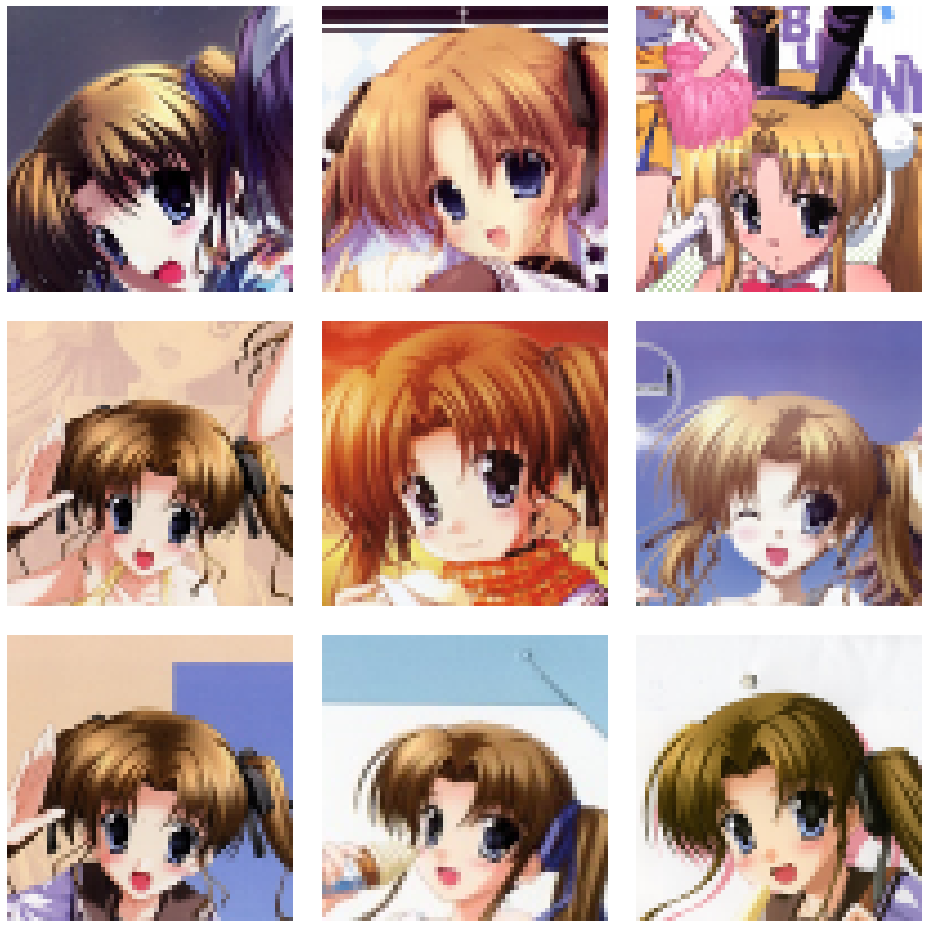

In [81]:
display_9_images_from_dataset(datasets)

### TFRecordに変換しGCSへアップロード

In [82]:
#再エンコード
def recompress_image(image):
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image

datasets_comp = datasets.map(recompress_image, num_parallel_calls=AUTOTUNE)
datasets_comp = datasets_comp.batch(shard_size) # 分割数ごとにバッチ化

In [83]:
#TFRecord変換コード
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

  
def to_tfrecord(img_bytes):  

  feature = {
      "image": _bytestring_feature([img_bytes]) # one image in the list
  }

  return tf.train.Example(features=tf.train.Features(feature=feature)) #tf.train.Exampleメッセージにする必要あり, feature=tf.train.Features(シリアライズされたfeatureインスタンス)


In [86]:
print("Writing TFRecords")

for shard, image in enumerate(datasets_comp):
  #バッチサイズを取得
  shard_size = image.numpy().shape[0]
  #ファイル名をつける (BP)
  filename = GCS_OUTPUT + "/{:02d}-{}.tfrec".format(shard, shard_size)

  #TFRecordに書き出し
  with tf.io.TFRecordWriter(filename) as out_file:
    #一枚ずつシリアライズ
    for i in range(shard_size):
      example = to_tfrecord(
                            image.numpy()[i]
                            )
      #シリアライズ化
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file gs://my-kaglle-getting-started/imoto-face/00-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/01-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/02-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/03-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/04-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/05-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/06-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/07-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/08-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/09-900.tfrec containing 900 records
Wrote file gs://my-kaglle-getting-started/imoto-face/10-900.tfrec containing 900 records
Wro

## ここから

### データセットをCGSからダウンロード

In [10]:
def read_tfrecord(example):
    #戻すfeature要素を定義
    features = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
        
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])

    return image

In [25]:
option_no_order = tf.data.Options()
option_no_order.deterministic  = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "/*.tfrec")
datasets = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
datasets = datasets.with_options(option_no_order)
datasets = datasets.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
datasets = datasets.shuffle(300)

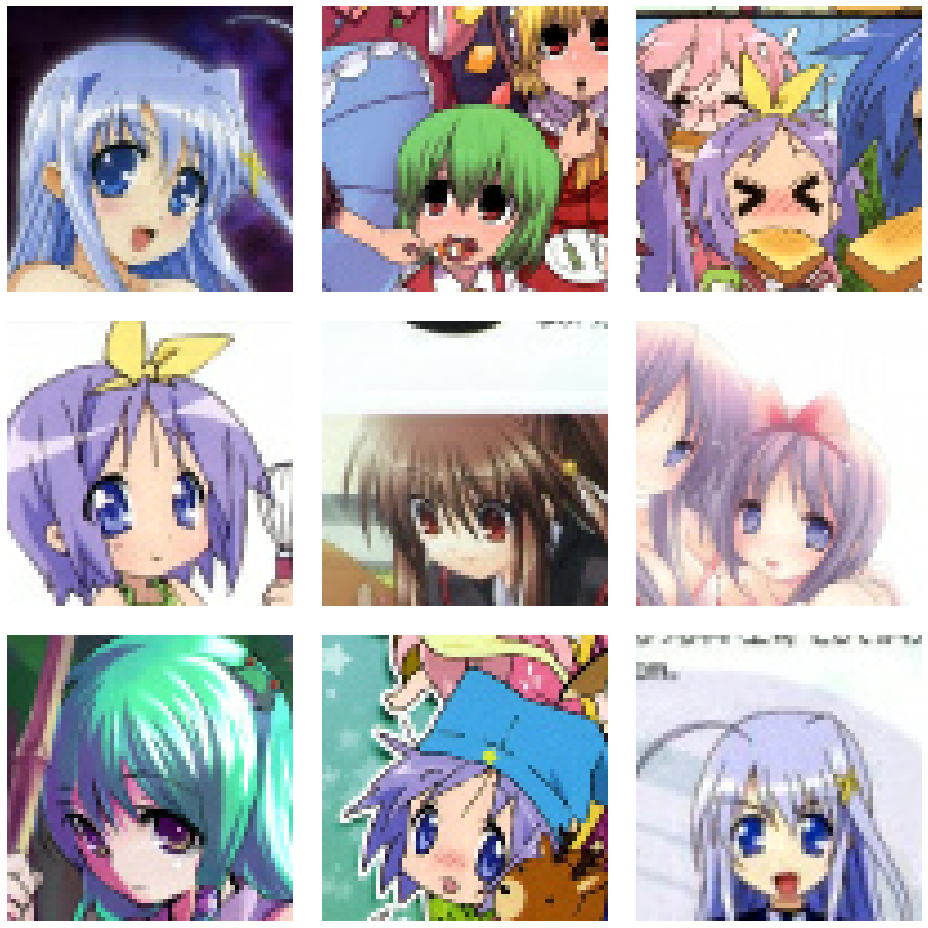

In [12]:
display_9_images_from_dataset(datasets)

In [13]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image

In [26]:
ds = datasets.map(preprocess)
ds

<MapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>

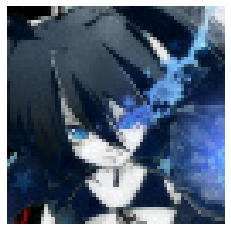

In [19]:
#確認
for x in datasets.take(1):
  plt.axis("off")
  plt.imshow((x.numpy()))

In [27]:
ds = ds.shuffle(buffer_size=nb_images)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

### ベースライン作成

In [59]:
#discriminator

def build_discriminator():
  input = layers.Input(shape=(64,64,3))
  feature = layers.Conv2D(64, (5,5), strides=(2,2), padding="same")(input) #カーネルを初期化していないのが気になる
  feature = layers.LeakyReLU()(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.Conv2D(64 * 2, (5,5), strides=(2,2), padding="same")(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.Conv2D(64 * 2 * 2, (5,5), strides=(2,2), padding="same")(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.Flatten()(feature)
  output = layers.Dense(1, activation="sigmoid")(feature)

  discriminator = tf.keras.Model(inputs = input , outputs = output)

  return discriminator

discriminator = build_discriminator()
discriminator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                           

In [58]:
#Generator
def build_generator():
  latent_dim = 100 #潜在次元が100
  input = layers.Input(shape = (100,))
  feature = layers.Dense(8*8*256, use_bias=False)(input) #バイアスなし 画像を膨らます
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Reshape((8,8,256))(feature)
  feature = layers.Conv2DTranspose(64 * 2 * 2 , (5,5) ,strides=(1,1), padding="same", use_bias=False)(feature) #第一層はStridesが(1,1)がBP
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Conv2DTranspose(64 * 2 , (5,5) ,strides=(2,2), padding="same", use_bias=False)(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Conv2DTranspose(64 , (5,5) ,strides=(2,2), padding="same", use_bias=False)(feature)
  feature = layers.BatchNormalization()(feature)
  feature = layers.LeakyReLU()(feature)
  feature = layers.Conv2DTranspose(3 , (5,5) ,strides=(2,2), padding="same", use_bias=False, activation="sigmoid")(feature)

  generator = tf.keras.Model(inputs=input, outputs=feature)

  return generator

generator = build_generator()
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_7 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 256)        1638400   
 ranspose)                                                 

In [17]:
class GAN(tf.keras.Model): #クラス作成
  def __init__(self, discriminator, generator, latent_dim):  #コンストラクタ
    super().__init__() #継承
    self.discriminator = discriminator #識別機 
    self.generator = generator #生成器
    self.latent_dim = latent_dim # 潜在次元
    #評価関数を定義
    self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss") #Batchすべての評価をとる.結果の平均をとる
    self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss") 

  def compile(self, d_optimizer, g_optimizer, loss_fn): #最適化を2つ作成
    super(GAN,self).compile() #継承
    self.d_optimizer = d_optimizer #discriminator用のOptimizer
    self.g_optimizer = g_optimizer #Generator用のOptimizer
    self.loss_fn = loss_fn

  @property
  def matrics(self):
    return [self.d_loss_metric, self.g_loss_metric] #評価関数を設定

  def train_step(self, real_images): #trainのoverride
    batch_size = tf.shape(real_images)[0] # (batch, height, width, channel) バッチ数を確保
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #バッチ数分潜在空間から画像の種を作成
    genereated_image = self.generator(random_latent_vectors) #画像を生成
    combined_image = tf.concat([real_images, genereated_image], axis=0) #縦に結合
    #真画像 : 1,  偽画像 : 0
    combined_label = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0) #ラベルを作成
    #学習を行う
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_image) #予測
      d_loss = self.loss_fn(combined_label, predictions) #損失を取得
      #d_loss = tf.reduce_sum(self.loss_fn(combined_label, predictions)) * (1. / 128)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #損失からウェイトを取得
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights)) #ウェイト調整

    #generator
    random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_label = tf.ones((batch_size, 1)) #真の値でラベルを付ける
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vector)) #偽画像を予測
      g_loss = self.loss_fn(misleading_label, predictions) #損失に入れる
      #g_loss = tf.reduce_sum(self.loss_fn(misleading_label, predictions)) * (1. / 128)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss) #損失から評価する
    self.g_loss_metric.update_state(g_loss) #損失から評価する
    return {"d_loss" : self.d_loss_metric.result(), "g_loss" : self.g_loss_metric.result()}


### コールバック

In [114]:
class GanMonitor(tf.keras.callbacks.Callback): #コールバック作成
  def __init__(self, log_dir, num_img = 3, latent_dim = 100):
    self.num_img = num_img #画像の生成数
    self.latent_dim = latent_dim #潜在次元
    self.log_dir = log_dir
  def on_epoch_end(self, epoch, logs=None): #エポックの後に動く画像
    random_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim )) #画像シード作成
    generated_imgs = self.model.generator(random_latent_vector)
    generated_imgs *= 255 #画像を復元
    generated_imgs = generated_imgs.numpy() #npに変換
    for idx, generated_img in enumerate(generated_imgs):
      pil_img = tf.keras.utils.array_to_img(generated_img)
      output_path = self.log_dir + f"/{time.time()}_{idx+1}.jpeg"
      pil_img.save(output_path)

In [85]:
#画像保存テスト
random_latent_vector = tf.random.normal(shape=(3, 100)) #画像シード作成
generated_imgs = generator(random_latent_vector)
generated_imgs *= 255 #画像を復元
generated_imgs = generated_imgs.numpy() #npに変換
generated_img = generated_imgs[0]
pil_img = tf.keras.utils.array_to_img(generated_img)
hoge = "/content/drive/MyDrive/data/imouto_face/GAN_result" + f"/{time.time()}.jpeg"
pil_img.save(hoge)

(64, 64, 3)

In [115]:
history = History() #履歴用のhistory

In [116]:
callbacks = [GanMonitor("/content/drive/MyDrive/data/imouto_face/GAN_result"), history]

In [117]:
with strategy.scope():
  
  generator = build_generator()
  discriminator = build_discriminator()
  model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
  model.compile(loss_fn=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE), 
              d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))  

d_loss, g_loss が収束しない
d_lossは最小化、g_lossは最大化しないといけないがどちらもうまくいっていない
Reductionの設定ミスでうまく表示されていないのか？

In [118]:
epochs = 200
steps_per_epoch = nb_images // BATCH_SIZE
model.fit(ds, epochs=epochs,  steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Epoch 1/200
  5/112 [>.............................] - ETA: 4s - d_loss: 0.6604 - g_loss: 0.6567WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 1.1560s). Check your callbacks.


112/112 [==============================] - 16s 32ms/step - d_loss: 0.2597 - g_loss: 2.5492
Epoch 2/200
112/112 [==============================] - 4s 36ms/step - d_loss: 0.4194 - g_loss: 3.1809
Epoch 3/200
112/112 [==============================] - 4s 38ms/step - d_loss: 0.1595 - g_loss: 3.9846
Epoch 4/200
112/112 [==============================] - 4s 39ms/step - d_loss: 0.1228 - g_loss: 5.2739
Epoch 5/200
112/112 [==============================] - 4s 33ms/step - d_loss: 0.1038 - g_loss: 5.7773
Epoch 6/200
112/112 [==============================] - 4s 33ms/step - d_loss: 0.1905 - g_loss: 4.9297
Epoch 7/200
112/112 [==============================] - 4s 32ms/step - d_loss: 0.1147 - g_loss: 4.6700
Epoch 8/200
112/112 [==============================] - 4s 34ms/step - d_loss: 0.0722 - g_loss: 4.8269
Epoch 9/200
112/112 [==============================] - 4s 33ms/step - d_loss: 0.0504 - g_loss: 6.6252
Epoch 10/200
112/112 [==============================] - 4s 34ms/step - d_loss: 0.5882 - g_los

KeyboardInterrupt: ignored

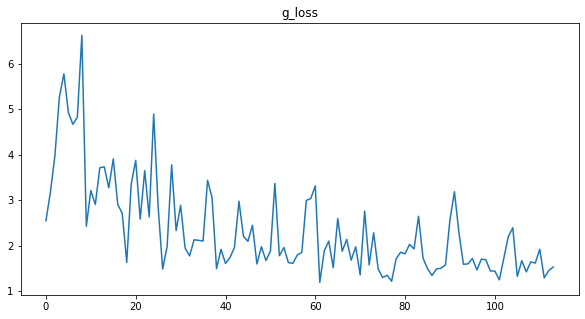

In [155]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["g_loss"])), y = history.history["g_loss"], ax=ax)
plt.title("g_loss")
plt.show()

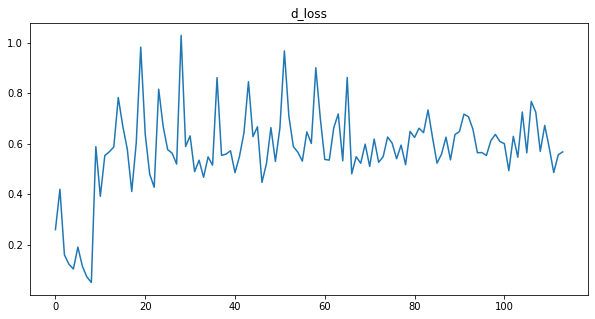

In [159]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = range(len(history.history["d_loss"])), y = history.history["d_loss"], ax=ax)
plt.title("d_loss")
plt.show()